# Init



In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import  Dropout, Dense
from keras.models import Sequential
from keras import backend as K
import tensorflow as tf
import plotly.graph_objects as go


import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
import nltk
import re

from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
ENG_SW = set(nltk.corpus.stopwords.words('english'))

In [4]:
seed = 42
np.random.seed(seed)

# Pre Proccess

In [6]:
df = pd.read_csv("onion-or-not.csv")

In [7]:
df.head(5)

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1


In [8]:
df["label"].value_counts()/len(df["label"])

0    0.625
1    0.375
Name: label, dtype: float64

In [26]:
pd.DataFrame(df["label"].replace({0:"Not Onion", 1:"Onion"}).value_counts())

,label
Not Onion,15000
Onion,9000


In [10]:
fig = px.pie(pd.DataFrame(df["label"].value_counts()), values='label', title='Source Distribution',names=["Not Onion","Onion"])
fig.show()

In [11]:
def prepossessing(df):

    df["text"] = df["text"].apply(lambda x : x.lower())
    df["text"] = df["text"].apply(lambda x :  re.sub('[^a-zA-z0-9\s]','',x)) 
    df["text_list"] = df["text"].apply(lambda x : nltk.word_tokenize(x))
    df["cleaned_list"] = df["text_list"].apply(lambda x: [word for word in x if word not in ENG_SW])
    df["stemmed_cleaned_list"] = df["cleaned_list"].apply(lambda x : [nltk.PorterStemmer().stem(i) for i in x])
    df['text_edited'] = df['stemmed_cleaned_list'].apply(lambda x : " ".join(x))

    return df['text_edited']

In [12]:
df_X = prepossessing(df)

In [13]:
df_Y = df['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.25, random_state=seed)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18000,) (18000,)
(6000,) (6000,)


# TF idf

In [15]:
vectorizer_x = TfidfVectorizer()

In [16]:
X_train_tfidf = vectorizer_x.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer_x.transform(X_test).toarray()

# Model

In [17]:
def Build_Model_DNN_Text(shape, optimizer='Adam', nLayers= 1, neurons=16, dropout=0.85):
    """
    Build_Model_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    """
    model = Sequential()
     # number of  hidden layer
    model.add(Dense(64,input_dim=shape,activation='elu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(neurons,input_dim=neurons,activation='elu'))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy',tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
    return model

#Val

In [18]:
model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1])
history = model_DNN.fit(X_train_tfidf, y_train,
                            validation_data=(X_test_tfidf, y_test),
                            epochs=100,
                            batch_size=4096,
                            verbose=2,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = "max", patience=10)]
                            )

Epoch 1/100
5/5 - 1s - loss: 0.6907 - accuracy: 0.5343 - auc: 0.5052 - precision: 0.3813 - recall: 0.3808 - val_loss: 0.6779 - val_accuracy: 0.6292 - val_auc: 0.7134 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
5/5 - 0s - loss: 0.6766 - accuracy: 0.5921 - auc: 0.5422 - precision: 0.4165 - recall: 0.2092 - val_loss: 0.6643 - val_accuracy: 0.6292 - val_auc: 0.8055 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
5/5 - 0s - loss: 0.6672 - accuracy: 0.6031 - auc: 0.5535 - precision: 0.4042 - recall: 0.1153 - val_loss: 0.6525 - val_accuracy: 0.6292 - val_auc: 0.8453 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
5/5 - 0s - loss: 0.6585 - accuracy: 0.6120 - auc: 0.5679 - precision: 0.4215 - recall: 0.0828 - val_loss: 0.6423 - val_accuracy: 0.6295 - val_auc: 0.8642 - val_precision: 1.0000 - val_recall: 8.9888e-04
Epoch 5/100
5/5 - 0s - loss: 0.6494 - accuracy: 0.6187 - auc: 0.5974 - precision: 0.4573 - recall: 0.0695 - val_loss: 0.6328 - v

In [19]:
model_DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1056448   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,057,505
Trainable params: 1,057,505
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_data = pd.DataFrame(history.history)

In [21]:
history_data

,loss,accuracy,auc,precision,recall,val_loss,val_accuracy,val_auc,val_precision,val_recall
0,0.690659,0.534333,0.505201,0.381262,0.380812,0.677900,0.629167,0.713398,0.000000,0.000000
1,0.676566,0.592056,0.542218,0.416520,0.209151,0.664296,0.629167,0.805493,0.000000,0.000000
2,0.667205,0.603056,0.553487,0.404244,0.115277,0.652508,0.629167,0.845346,0.000000,0.000000
3,0.658539,0.612000,0.567950,0.421488,0.082804,0.642341,0.629500,0.864246,1.000000,0.000899
4,0.649432,0.618722,0.597385,0.457282,0.069520,0.632801,0.630333,0.876934,1.000000,0.003146
5,0.638324,0.626944,0.632169,0.535629,0.066568,0.622918,0.634167,0.883068,1.000000,0.013483
6,0.628236,0.643778,0.669072,0.686154,0.098745,0.612213,0.650167,0.887703,0.970149,0.058427
7,0.613589,0.670722,0.718804,0.796919,0.167970,0.600333,0.686167,0.891099,0.964674,0.159551
8,0.598748,0.697611,0.767773,0.832004,0.246347,0.586700,0.726000,0.893330,0.920405,0.285843
9,0.585128,0.721056,0.797099,0.843383,0.317934,0.571071,0.755500,0.895172,0.894792,0.386067


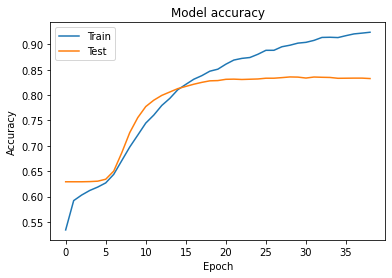

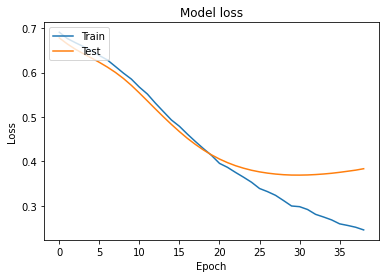

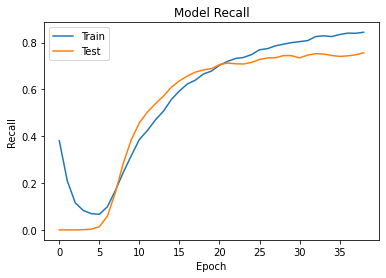

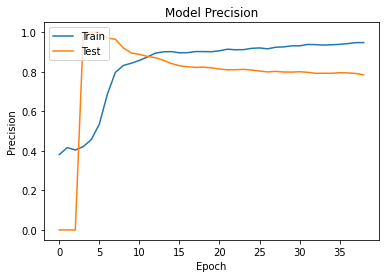

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
results = model_DNN.evaluate(X_test_tfidf, y_test, verbose=False)

In [25]:
print("Testing")
print("LOSS : {:.4f}\nBINARY_ACC : {:.4f}\nAUC : {:.4f}\nPRECISION : {:.4f}\nRECALL : {:.4f}".format(*results))

Testing
LOSS : 0.3834
BINARY_ACC : 0.8325
AUC : 0.9054
PRECISION : 0.7845
RECALL : 0.7560


#Grid Search

In [ ]:
X = vectorizer_x.fit_transform(df_X).toarray()

In [ ]:
#######################################################
## Neurons
## Dropout

In [ ]:
# define the grid search parameters
hidden = [1,2]
neurons = [16,32,64]
drops = [0.85]
param_grid = dict(dropout=drops, neurons=neurons, nLayers=hidden)

In [ ]:
model = KerasClassifier(build_fn=Build_Model_DNN_Text, epochs=20, batch_size=2048, verbose=0, shape = X.shape[1], optimizer='Adam')

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=1, verbose=2)
grid_result = grid.fit(X, df_Y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] dropout=0.85, nLayers=1, neurons=16 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. dropout=0.85, nLayers=1, neurons=16, total=  25.5s
[CV] dropout=0.85, nLayers=1, neurons=16 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] .............. dropout=0.85, nLayers=1, neurons=16, total=  25.1s
[CV] dropout=0.85, nLayers=1, neurons=16 .............................
[CV] .............. dropout=0.85, nLayers=1, neurons=16, total=  25.2s
[CV] dropout=0.85, nLayers=1, neurons=32 .............................
[CV] .............. dropout=0.85, nLayers=1, neurons=32, total=  25.2s
[CV] dropout=0.85, nLayers=1, neurons=32 .............................
[CV] .............. dropout=0.85, nLayers=1, neurons=32, total=  25.6s
[CV] dropout=0.85, nLayers=1, neurons=32 .............................
[CV] .............. dropout=0.85, nLayers=1, neurons=32, total=  25.3s
[CV] dropout=0.85, nLayers=1, neurons=64 .............................
[CV] .............. dropout=0.85, nLayers=1, neurons=64, total=  25.2s
[CV] dropout=0.85, nLayers=1, neurons=64 .............................
[CV] .............. dropout=0.85, nLayers=1, neurons=64, total=  25.1s
[CV] dropout=0.85, nLayers=1, neurons=64 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.5min finished


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.836375 using {'dropout': 0.85, 'nLayers': 1, 'neurons': 16}
0.836375 (0.002477) with: {'dropout': 0.85, 'nLayers': 1, 'neurons': 16}
0.832000 (0.001987) with: {'dropout': 0.85, 'nLayers': 1, 'neurons': 32}
0.829500 (0.002624) with: {'dropout': 0.85, 'nLayers': 1, 'neurons': 64}
0.835083 (0.002399) with: {'dropout': 0.85, 'nLayers': 2, 'neurons': 16}
0.833792 (0.002536) with: {'dropout': 0.85, 'nLayers': 2, 'neurons': 32}
0.830292 (0.002359) with: {'dropout': 0.85, 'nLayers': 2, 'neurons': 64}
